In [3]:
from sklearn import datasets
digits = datasets.load_digits()
print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [4]:
# summary of data
print('data size = ', digits.data.shape)
print('target size = ', digits.target.shape)
print(digits.DESCR)

 recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input 

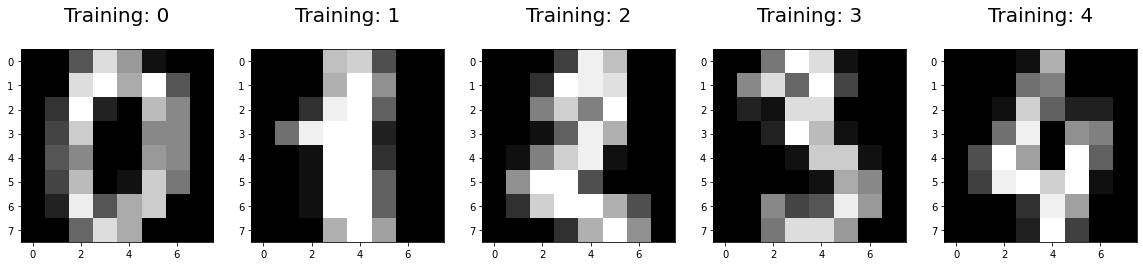

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# show examples of dataset
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

In [6]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=8)
print(X_train[256], y_train[256])

[ 0.  0.  2. 16. 10.  0.  0.  0.  0.  0.  4. 16. 16.  5.  0.  0.  0.  0.
  8. 16. 16.  3.  0.  0.  0.  0.  9. 16. 16.  3.  0.  0.  0.  0.  8. 16.
 16.  3.  0.  0.  0.  0.  8. 16. 16.  1.  0.  0.  0.  0.  5. 16. 14.  0.
  0.  0.  0.  0.  1. 12. 16.  3.  0.  0.] 1


In [15]:
def permute_array(vector):
    permut = np.zeros((vector.shape[0], vector.max()+1))
    permut[np.arange(vector.shape[0]), vector] = 1
    return permut

# 3.2 batch gradient descent (GD) for Logistic regression
def LogisticRegression_GD(X_train, y_train, learning_rate):
    epsilon = 1.0e-4
    eta = 0.1

    n, m = np.shape(X_train)
    y_train_binary = permute_array(y_train)
    
    # W is m x c - but include an extra row to account for b. We will also append an additional column to x such that the size of x is (n x (m + 1)).
    W = np.ones(shape=(m+1, np.amax(y_train)+1))

    new_col = np.ones(shape=(n, 1))
    X = np.append(X_train, new_col, axis=1)

    # Calculate the first value for loss with initial values for W
    z = X @ W
    z = z - np.max(z, axis=1)[:, None]    
    pr = np.exp(z) / np.sum(np.exp(z), axis=1)[:,None]
    
    loss = -1/(n+1) * np.sum(y_train @ np.log(pr)) + eta / 2 * np.linalg.norm(W)
    i = 1
    
    # Emulate a do-while loop so, exit loop once the loss starts to reach steady-state (i.e. a differential between iterations of less than epsilon)
    while True:
        # Calculate the gradient of F(W), apply gradient to W
        grad = 1/(n+1) * X.transpose() @ (pr - y_train_binary) + eta * W
        W = W - learning_rate * grad

        # Calculate the loss at the next iteration
        z = X @ W
        z = z - np.max(z, axis=1)[:, None]    
        pr = np.exp(z) / np.sum(np.exp(z), axis=1)[:,None]
        
        loss = np.append(loss, -1/(n+1) * np.sum(y_train @ np.log(pr)) + eta / 2 * np.linalg.norm(W))

        # Compare the loss between two iterations, if the loss if less than or equal to epsilon then break out of the while loop
        if (np.absolute(loss[i] - loss[i-1]) <= epsilon):
            break
        
        #if i% 1000 == 0:
            #print(loss[i], loss[i-1], np.absolute(loss[i] - loss[i-1]))
        i+=1

    # Extract W and b from 'compressed' version of W
    b = W[m, :]
    W = np.delete(W, 1, 0)

    return W, b, loss

---------------------------------------
learning rate = 0.05
training precision = 0.42835931700074237
test precision = 0.44666666666666666
---------------------------------------
learning rate = 0.005
training precision = 0.42538975501113585
test precision = 0.4488888888888889
---------------------------------------
learning rate = 0.01
training precision = 0.42538975501113585
test precision = 0.4488888888888889


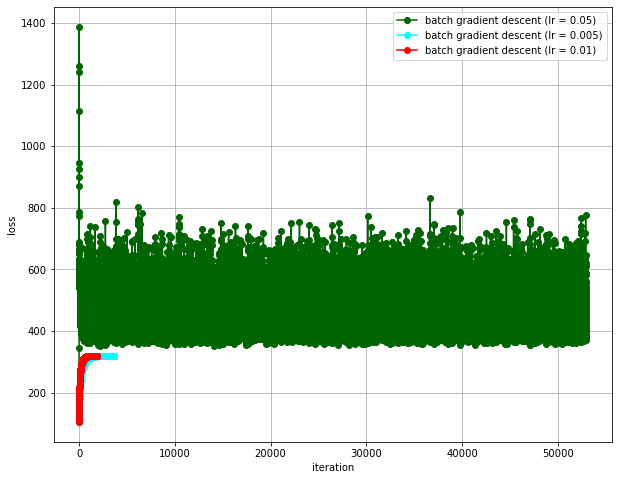

In [16]:
# evaluation of different learning rate
learning_rate = [5.0e-2, 5.0e-3, 1.0e-2]

cl = ['darkgreen', 'cyan', 'red']
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(len(learning_rate)):
    
    print('---------------------------------------')
    print('learning rate =', learning_rate[i])
    
    W, b, loss_GD = LogisticRegression_GD(X_train, y_train, learning_rate[i])
    
    z = X_train @ W + b
    y_bar = np.exp(z) / np.sum(np.exp(z), axis=1)[:,None]
    prec_train = np.count_nonzero((np.argmax(y_bar, axis=1) == y_train)) / np.size(y_train)
    print('training precision =', prec_train)

    z = X_test @ W + b
    y_bar = np.exp(z) / np.sum(np.exp(z), axis=1)[:,None]
    prec_test = np.count_nonzero((np.argmax(y_bar, axis=1) == y_test)) / np.size(y_test)
    print('test precision =', prec_test)
    
    plt.plot(loss_GD, c = cl[i], ls = '-', marker = 'o', label = 'batch gradient descent (lr = ' + str(learning_rate[i]) + ')')

plt.grid()
plt.legend()
plt.xlabel('iteration')
plt.ylabel('loss')
fig.show()
plt.savefig('Problem_4_b_2.png')

In [27]:
# 3.3 stochastic gradient descent (SGD) for Logistic regression

def LogisticRegression_SGD(X, y, batch_size, lr=1.0e-2, eta=2.0e-1, eps = 1.0e-4, max_epoch=500):
    
    #TODO: initialization
    notstop = True
    epoch = 0
    loss = []    

    # optimization loop	
    while notstop and epoch < max_epoch:
        
        #TODO: SGD of each epoch
        
        # half lr if not improving in 10 epochs
        if epoch > 10:
            if loss[epoch - 10] <= loss[epoch] - eps:
                lr *= 0.5
                print 'reduce learning rate to', lr
        
        # stop if not improving in 20 epochs
        if epoch > 20:
            if loss[epoch - 20] <= loss[epoch] - eps or abs(loss[epoch] - loss[epoch-1]) <= eps:                
                notstop = False
                break
            
        epoch += 1
        
        #TODO: W and b

    return (W, b, loss)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('reduce learning rate to', lr)? (<ipython-input-27-3096cd987196>, line 19)

In [ ]:
# evaluation of different batch size
bs = [10, 50, 100]
cl = ['green', 'blue', 'orange']
# TODO: different learning rate for different batch size
lr = []
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(bs)):
    
    print '---------------------------------------'
    print 'batch_size =', bs[i]
    W, b, loss_SGD = LogisticRegression_SGD(X_train, y_train, bs[i], lr[i], eta = 2.0e-1, eps = 1.0e-4, max_epoch = 500)
    
    #TODO
    print 'training precision =', prec_train

    #TODO
    print 'test precision =', prec_test
    
    plt.plot(loss_SGD, c = cl[i], ls = '-', marker = 'o', label = 'stochastic gradient descent (batch_size = ' + str(bs[i]) + ')')

plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')